In [1]:
from geodude.utils import Paper, merge_LineStrings
import vsketch
import numpy as np
from shapely.geometry import (
    box, 
    MultiLineString, 
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString,
    )

from fn.fn import new_savepath
from geodude.ops import make_like
from shapely import is_valid, unary_union
import itertools
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from geodude.line import dash_linestring, bezier_func
from geodude.intersection import (
    pairwise_partition_polygons, 
    polys_to_gdf, 
    find_intersecting_polys,
    find_touching_polys, 
    find_clusters, 
    find_contained_polys, 
    find_parent_polygons,
    merge_disjoint_polys,
    assign_random_order_to_adjacent_clusters,
    assign_psuedoperiodic_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons
    )
from geodude.ops import buft_fill
from geodude.parameter import Prm, prms

%load_ext autoreload
%autoreload 2

In [2]:

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [47]:

n_lines = 40
xmin, ymin, xmax, ymax = drawbox.bounds
width = xmax - xmin


des_xmin = xmin + width * 0.2
des_xmax = xmax - width * 0.2
des_xrange = (des_xmin, des_xmax)


init_rel_xs = np.linspace(0, 1, n_lines)



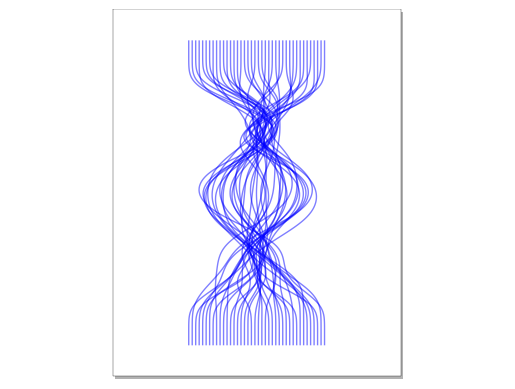

In [48]:
def get_ctrl_pts(x,):
    xs = [
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.random.uniform(-1, 2),
        np.random.uniform(0, 2),
        np.random.uniform(0, 2),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0.2, 0.8],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        
    ]
    xs = np.interp(xs, [0, 1], des_xrange,)
    ys = np.linspace(ymin, ymax, len(xs))
    return list(zip(xs, ys))


ctrl_pt_sets = [get_ctrl_pts(x) for x in init_rel_xs]
bezier_funcs = [bezier_func(ctrl_pts) for ctrl_pts in ctrl_pt_sets]
n_eval_pts = 200
eval_pts = np.linspace(0,1,n_eval_pts)
lines = [bezier_func(eval_pts) for bezier_func in bezier_funcs]

mls = MultiLineString(lines)

sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.05mm')

sk.geometry(mls)
sk.display()

In [49]:
buffed = [l.buffer(1.4, cap_style='square') for l in mls.geoms]

In [50]:
gdf = polys_to_gdf(buffed)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    )

Iteration 1
Finding intersections in 40 polygons
1560 intersections remaining
Chunking polygons
Partitioning 4 chunks


4it [00:00, 25.91it/s]


Iteration 1 complete, 203 polygons remaining
Iteration 2
Finding intersections in 203 polygons
5162 intersections remaining
Chunking polygons
Partitioning 20 chunks


20it [00:03,  6.57it/s]


Iteration 2 complete, 904 polygons remaining
Iteration 3
Finding intersections in 904 polygons
8912 intersections remaining
Chunking polygons
Partitioning 82 chunks


82it [00:07, 10.67it/s]


Iteration 3 complete, 2071 polygons remaining
Iteration 4
Finding intersections in 2071 polygons
12370 intersections remaining
Chunking polygons
Partitioning 189 chunks


189it [00:12, 14.90it/s]


Iteration 4 complete, 3447 polygons remaining
Iteration 5
Finding intersections in 3447 polygons
12998 intersections remaining
Chunking polygons
Partitioning 289 chunks


289it [00:15, 18.70it/s]


Iteration 5 complete, 4339 polygons remaining
Iteration 6
Finding intersections in 4339 polygons
11226 intersections remaining
Chunking polygons
Partitioning 334 chunks


334it [00:15, 21.12it/s] 


Iteration 6 complete, 4437 polygons remaining
Iteration 7
Finding intersections in 4437 polygons
8186 intersections remaining
Chunking polygons
Partitioning 310 chunks


310it [00:13, 23.07it/s]


Iteration 7 complete, 3711 polygons remaining
Iteration 8
Finding intersections in 3711 polygons
5258 intersections remaining
Chunking polygons
Partitioning 239 chunks


239it [00:08, 27.99it/s]


Iteration 8 complete, 2611 polygons remaining
Iteration 9
Finding intersections in 2611 polygons
3290 intersections remaining
Chunking polygons
Partitioning 166 chunks


166it [00:05, 31.33it/s]


Iteration 9 complete, 1777 polygons remaining
Iteration 10
Finding intersections in 1777 polygons
2164 intersections remaining
Chunking polygons
Partitioning 113 chunks


113it [00:03, 30.07it/s]


Iteration 10 complete, 1231 polygons remaining
Iteration 11
Finding intersections in 1231 polygons
1396 intersections remaining
Chunking polygons
Partitioning 77 chunks


77it [00:02, 31.92it/s]


Iteration 11 complete, 792 polygons remaining
Iteration 12
Finding intersections in 792 polygons
910 intersections remaining
Chunking polygons
Partitioning 50 chunks


50it [00:01, 34.07it/s]


Iteration 12 complete, 537 polygons remaining
Iteration 13
Finding intersections in 537 polygons
626 intersections remaining
Chunking polygons
Partitioning 36 chunks


36it [00:01, 27.51it/s]


Iteration 13 complete, 403 polygons remaining
Iteration 14
Finding intersections in 403 polygons
352 intersections remaining
Chunking polygons
Partitioning 23 chunks


23it [00:01, 18.35it/s]


Iteration 14 complete, 242 polygons remaining
Iteration 15
Finding intersections in 242 polygons
76 intersections remaining
Chunking polygons
Partitioning 6 chunks


6it [00:00, 22.37it/s]


Iteration 15 complete, 63 polygons remaining
Iteration 16
Finding intersections in 63 polygons
6 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 45.31it/s]

Iteration 16 complete, 7 polygons remaining
Iteration 17
Finding intersections in 7 polygons
0 intersections remaining
Chunking polygons


In [52]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)


In [92]:

ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-1
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


In [93]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



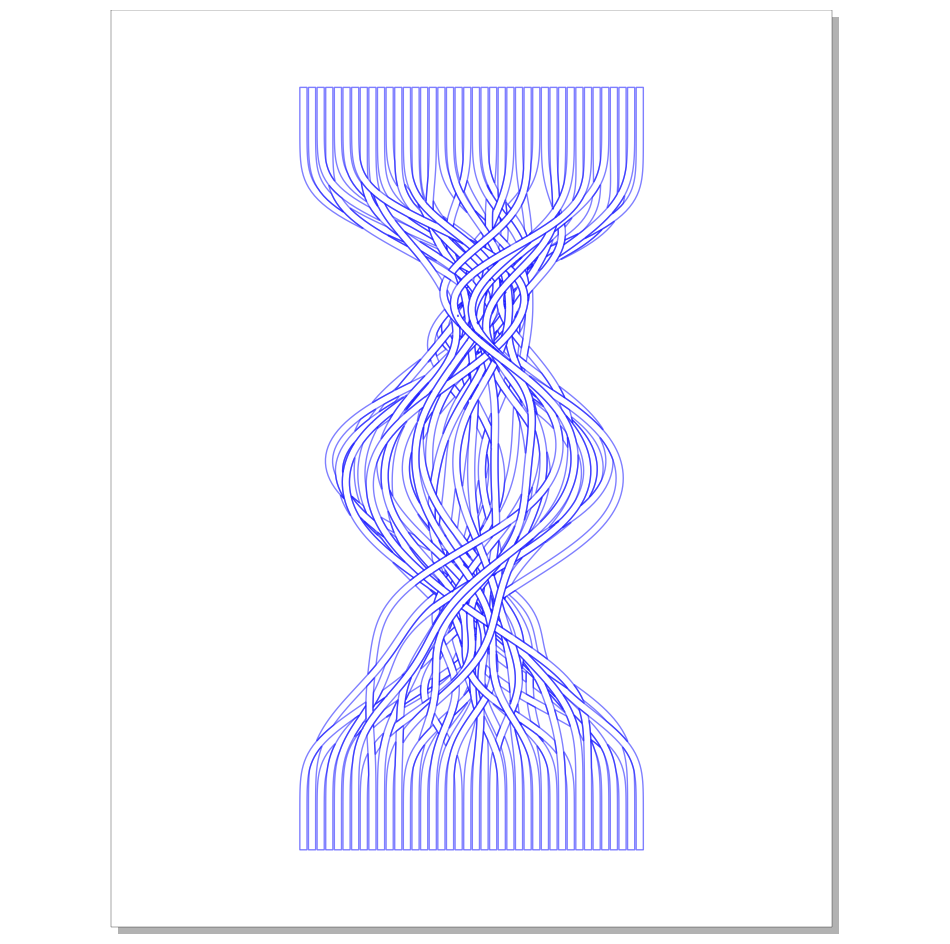

In [94]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))


In [56]:
sk.vpype('splitall linemerge linesort')

In [57]:
fp = new_savepath(postfix='weave')
sk.save(fp)

In [11]:
fills = []
for geom in gdf.geometry:
    d_buffer = Prm(-0.3)
    d_translate = Prm(lambda : d_buffer() * 0.9)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)

In [12]:
fill_gdf = polys_to_gdf(fills)

In [14]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))

In [22]:
masked = pd.concat(masked)

In [23]:
masked = masked[~masked.is_empty]

In [24]:
fill_mls = merge_LineStrings(masked.to_list())

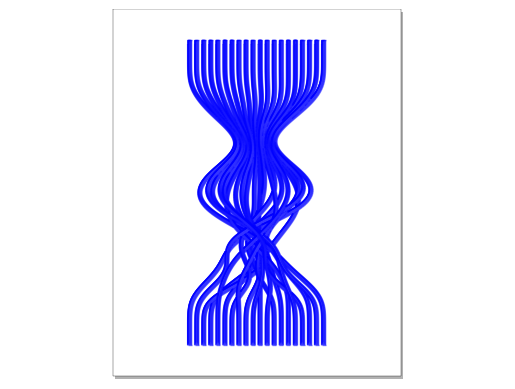

In [25]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display()

In [26]:
sk.vpype('splitall linemerge linesort')

In [27]:
fp = new_savepath(postfix='filled_weave')
sk.save(fp)

# more interesting starts

In [128]:

n_lines = 70
xmin, ymin, xmax, ymax = drawbox.bounds
width = xmax - xmin
height = ymax - ymin

des_xmin = xmin + width * 0.2
des_xmax = xmax - width * 0.2
des_xrange = (des_xmin, des_xmax)

des_ymin = ymin + height * 0.2
des_ymax = ymax - height * 0.2
des_yrange = (des_ymin, des_ymax)


degs = np.linspace(0, 360, n_lines)
init_xs = np.cos(np.deg2rad(degs)) * 0.2
init_ys = np.sin(np.deg2rad(degs)) * 0.2 - 0.8
init_pts = [Point(x,y) for x,y in zip(init_xs, init_ys)]

final_xs = np.cos(np.deg2rad(degs)) * 0.03
final_ys = np.sin(np.deg2rad(degs)) * 0.2 + 0.8
final_pts = [Point(x,y) for x,y in zip(final_xs, final_ys)]

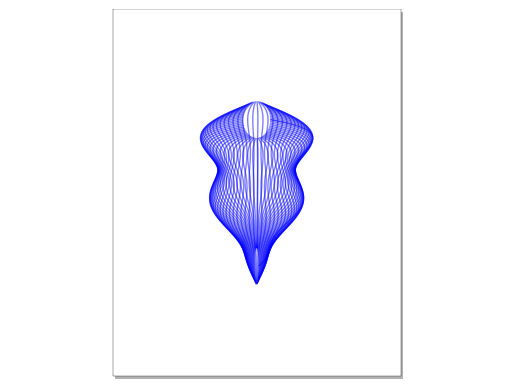

In [129]:
def get_ctrl_pts(init_pt, end_pt):
    x_init = init_pt.x
    y_init = init_pt.y
    
    x_end = end_pt.x
    y_end = end_pt.y
    xs = [
        x_init,
        np.interp(x_init, [-1, 1], [-5, 5],),
        np.interp(x_init, [-1, 1], [-5, 5],),
        np.interp(x_init, [-1, 1], [-5, 5],),
        np.interp(x_init, [-1, 1], [-2, 2],),
        np.interp(x_init, [-1, 1], [-2, 2],),
        np.interp(x_init, [-1, 1], [-2, 2],),
        np.interp(x_init, [-1, 1], [-2, 2],),
        
        np.interp(x_init, [-1, 1], [-5, 5],),
        np.interp(x_init, [-1, 1], [-5, 5],),
        np.interp(x_init, [-1, 1], [-5, 5],),
        
        
        # np.random.uniform(-1, 1),
        # np.random.uniform(-1, 1),
        
        np.interp(x_init, [-1, 1], [-1, 1],),
        np.interp(x_init, [-1, 1], [-1, 1],),
        np.interp(x_init, [-1, 1], [-1, 1],),
        np.interp(x_init, [-1, 1], [-1, 1],),
        np.interp(x_init, [-1, 1], [-1, 1],),
        x_end,
    ]
    xs = np.interp(xs, [-1, 1], des_xrange,)
    # ys = [
    #     y_init,
    #     np.random.uniform(-1, 1),
    #     y_end,
    # ]
    ys = np.linspace(y_init, y_end, len(xs))
    ys = np.interp(ys, [-1, 1], des_yrange)
    return list(zip(xs, ys))


ctrl_pt_sets = [get_ctrl_pts(init_pt, end_pt) for init_pt, end_pt in zip(init_pts, final_pts)]
bezier_funcs = [bezier_func(ctrl_pts) for ctrl_pts in ctrl_pt_sets]
n_eval_pts = 200
eval_pts = np.linspace(0,1,n_eval_pts)
lines = [bezier_func(eval_pts) for bezier_func in bezier_funcs]

mls = MultiLineString(lines)

sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.05mm')

sk.geometry(mls)
sk.display()

In [130]:
buffed = [l.buffer(1., cap_style='round') for l in mls.geoms]

In [131]:
gdf = polys_to_gdf(buffed)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-2,
    )

Iteration 1
Finding intersections in 70 polygons
2364 intersections remaining
Chunking polygons
Partitioning 7 chunks


7it [00:00, 13.24it/s]


Iteration 1 complete, 207 polygons remaining
Iteration 2
Finding intersections in 207 polygons
3542 intersections remaining
Chunking polygons
Partitioning 20 chunks


20it [00:03,  6.11it/s]


Iteration 2 complete, 881 polygons remaining
Iteration 3
Finding intersections in 881 polygons
6048 intersections remaining
Chunking polygons
Partitioning 77 chunks


77it [00:06, 12.60it/s]


Iteration 3 complete, 1668 polygons remaining
Iteration 4
Finding intersections in 1668 polygons
7194 intersections remaining
Chunking polygons
Partitioning 136 chunks


136it [00:09, 14.43it/s]


Iteration 4 complete, 2679 polygons remaining
Iteration 5
Finding intersections in 2679 polygons
6784 intersections remaining
Chunking polygons
Partitioning 192 chunks


192it [00:10, 17.97it/s]


Iteration 5 complete, 3069 polygons remaining
Iteration 6
Finding intersections in 3069 polygons
5038 intersections remaining
Chunking polygons
Partitioning 193 chunks


193it [00:09, 20.87it/s]


Iteration 6 complete, 2674 polygons remaining
Iteration 7
Finding intersections in 2674 polygons
3012 intersections remaining
Chunking polygons
Partitioning 142 chunks


142it [00:06, 23.14it/s]


Iteration 7 complete, 1741 polygons remaining
Iteration 8
Finding intersections in 1741 polygons
1554 intersections remaining
Chunking polygons
Partitioning 86 chunks


86it [00:03, 22.22it/s]


Iteration 8 complete, 974 polygons remaining
Iteration 9
Finding intersections in 974 polygons
658 intersections remaining
Chunking polygons
Partitioning 40 chunks


40it [00:01, 28.08it/s]


Iteration 9 complete, 401 polygons remaining
Iteration 10
Finding intersections in 401 polygons
376 intersections remaining
Chunking polygons
Partitioning 22 chunks


22it [00:00, 28.46it/s]


Iteration 10 complete, 241 polygons remaining
Iteration 11
Finding intersections in 241 polygons
218 intersections remaining
Chunking polygons
Partitioning 14 chunks


14it [00:00, 20.89it/s]


Iteration 11 complete, 163 polygons remaining
Iteration 12
Finding intersections in 163 polygons
80 intersections remaining
Chunking polygons
Partitioning 6 chunks


6it [00:00, 23.34it/s]


Iteration 12 complete, 59 polygons remaining
Iteration 13
Finding intersections in 59 polygons
22 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 26.95it/s]


Iteration 13 complete, 15 polygons remaining
Iteration 14
Finding intersections in 15 polygons
0 intersections remaining
Chunking polygons


In [132]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)


In [133]:

ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-1
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


In [134]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



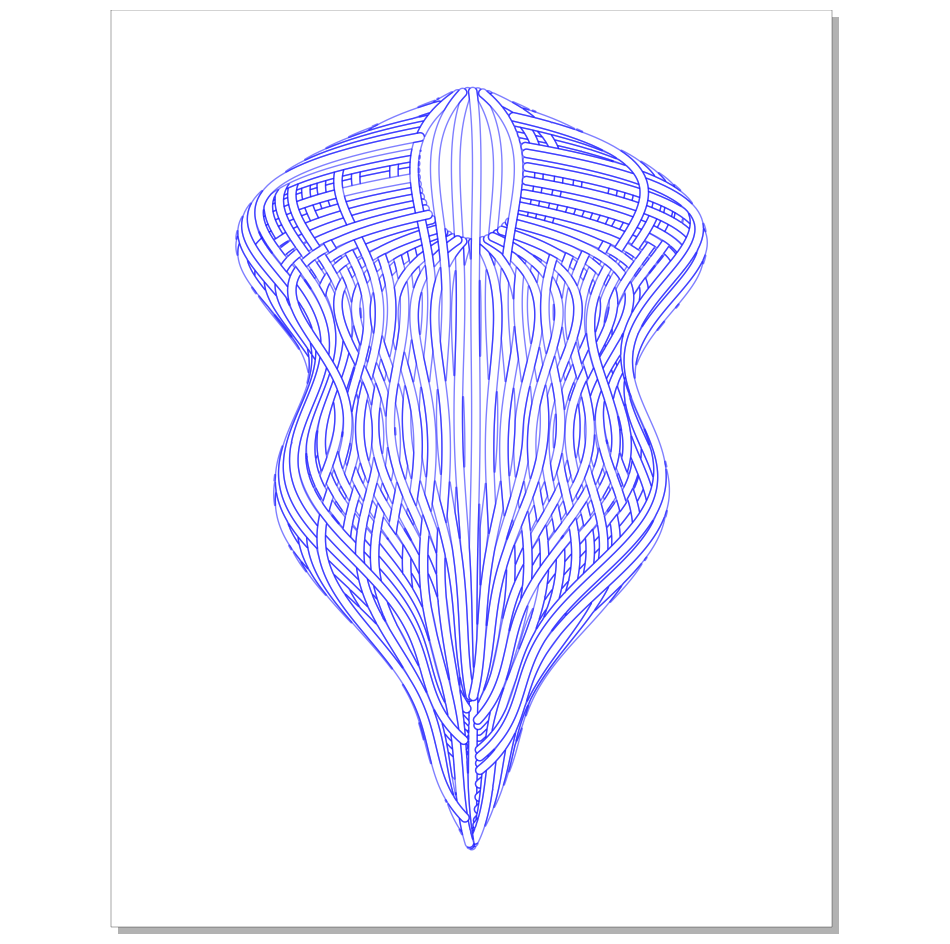

In [135]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))


In [ ]:
sk.vpype('splitall linemerge linesort')

In [ ]:
fp = new_savepath(postfix='weave')
sk.save(fp)